In [6]:
############################
# IMPORTACION DE LIBRERIAS #
############################

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

#warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


In [7]:
##################
# CARGA DE DATOS #
##################

traindata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TRAIN.txt')#reading the data
testdata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TEST.txt')
print('Number of rows and columns of the training set: ',traindata.shape)
print('Number of rows and columns of the test set: ',testdata.shape)

/home/rafa/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of rows and columns of the training set:  (363834, 89)
Number of rows and columns of the test set:  (156315, 88)


In [8]:
#####################################
# SEPARACION DE VARIABLES POR TIPOS #
#####################################

numeric_cols=traindata.select_dtypes(include=[np.number]).columns#select only numerical
nominal_cols=traindata.select_dtypes(exclude=[np.number]).columns#select only non numerical
print(numeric_cols.shape[0],'numeric columns') #: ',numeric_cols)
print(nominal_cols.shape[0],'nominal columns') #: ',nominal_cols)

87 numeric columns
2 nominal columns


In [16]:
###############################################
# FUNCIONES PARA PREPROCESADO Y VISUALIZACION #
###############################################

#RANGO INTERCUARTILICO
def iqr_calculate(column):
    description = column.describe()
    iqr = description['75%']-description['25%']
    return iqr

#LIMITES VALORES ATIPICOS
def outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-1.5*iqr,description['75%']+1.5*iqr]
    return outliers_limits

#LIMITES VALORES ATIPICOS EXTREMOS
def extreme_outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-3*iqr,description['75%']+3*iqr]
    return outliers_limits

#MOSTRAR HISTOGRAMA PARA UNA COLUMNA DADA
def mostrar_histograma(column, bins=100, label = None):
    print('Histograma:')
    fig, ax = plt.subplots()
    ax.hist(column, bins)
    ax.set_xlabel(label)
    plt.show()

#ELIMINA VALORES ATIPICOS
def delete_outliers(data, column):
    limits = outliers_limits(column)
    data_without_outliers = data[column<=limits[1]]
    data_without_outliers = data_without_outliers[column>=limits[0]]
    return data_without_outliers

#ELIMINA VALORES ATIPICOS EXTREMOS
def delete_extreme_outliers(data, column):
    limits = extreme_outliers_limits(column)
    data_without_extreme_outliers = data[column<=limits[1]]
    data_without_extreme_outliers = data_without_extreme_outliers[column>=limits[0]]
    return data_without_extreme_outliers
    
#MUESTRA DIAGRAMA DE CAJAS
def mostrar_diagrama_cajas(column):
    print('Diagrama de cajas:')
    plt.boxplot(column, vert=False)
    plt.show()

#MUESTRA LA MATRIZ DE CORRELACIONES
def mostrar_matriz_correlacion(data):
    print('Matriz de correlaciones:')
    correlation=data.corr() #obtain the correlation matrix
    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation,ax=ax)
    plt.show()

#MUESTRA MATRIZ CON VARIABLES DE FUERTE CORRELACION
def mostrar_matriz_correlacion_fuerte(data, valor = 0.7):  
    print('Matriz de correlaciones de variables con correlacion superior a ', valor, ':')
    correlation=data.corr() #obtain the correlation matrix
    aux=(abs(correlation)-np.identity(correlation.shape[0])).max() #maximum correlation of each variable
    selected_feats=aux[aux>valor].index#take only variables whose maximum correlation is strong.
    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation.loc[selected_feats,selected_feats],ax=ax,annot=True,fmt='.2f')
    plt.show()
    
#MUESTRA MATRIZ DE CORRELACION CON LAS N VARIABLES MAS FUERTES
def mostrar_matriz_correlacion_variables_fuertes(data, variables = 20):  
    print('Matriz de correlaciones de las ', variables, ' variables mas fuertes:')
    correlation=data.corr()
    aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False) #sort variables by their correlation with SalePrice
    selected_feats=aux[0:variables].index
    sns.set()
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
    plt.show()

    
#MUESTRA LA MATRIZ DE DISPERSION
def mostrar_matriz_dispersion(data):
    print('Matrices de dispersion:')
    correlation=data.corr() #obtain the correlation matrix
    sns.set(style="ticks")
    sns.pairplot(correlation)
    plt.show()
    
#MUESTRA MATRIZ DE DISPERSION CON VARIABLES DE FUERTE CORRELACION
def mostrar_matriz_dispersion_variables_fuertes(data, valor = 0.7):
    print('Matrices de dispersion de variables con correlacion superior a ', valor, ':')
    correlation = data.corr()
    aux=abs(correlation)-np.identity(correlation.shape[0]).max()
    selected_feats=aux[aux>valor].index
    sns.set(style="ticks")
    sns.pairplot(data[selected_feats])
    plt.show()
    
#MUESTRA MATRIZ DE DISPERSION DE LAS N VARIABLES MAS FUERTES
def mostrar_matriz_dispersion_variables_fuertes(data, variables = 20):
    print('Matrices de disperion de las ', variables, ' variables mas fuertes:')
    correlation = data.corr()
    aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False)
    selected_feats=aux[0:variables].index
    sns.set(style="ticks")
    sns.pairplot(data[selected_feats])
    plt.show()

#SELECCIONA BLOQUE DE DATOS
def mostrar_histograma_bloque(bloque = 'Imp_Cons'):
    for col in numeric_cols:
        if(col.find(bloque) != -1):
           print(col)
           mostrar_histograma(traindata_without_outliers[col], 50)

/home/rafa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/rafa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Matrices de disperion de las  5  variables mas fuertes:


KeyboardInterrupt: 

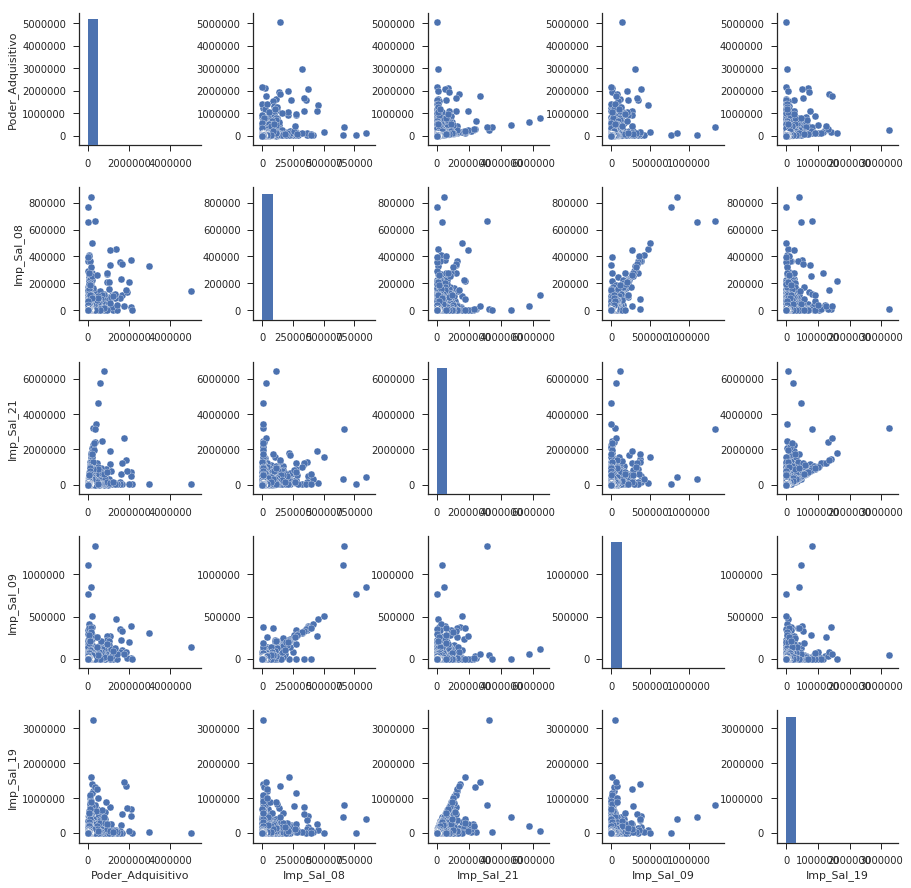

In [10]:
##########################
# VISUALIZACION DE DATOS #
##########################

# CONFIGURACION DE DATOS A VISUALIZAR
visualizar_rangos = 0
visualizar_histogramas = 0
visualizar_diagramas_cajas = 0
visualizar_matrices_correlacion = 0
visualizar_matrices_dispersion = 1


# GENERACION DE DISTINTOS DATASETS
traindata_without_outliers = delete_outliers(traindata, traindata['Poder_Adquisitivo'])
traindata_without_extreme_outliers = delete_extreme_outliers(traindata, traindata['Poder_Adquisitivo'])
    
    
if (visualizar_rangos == 1):
    ###################
    # RANGOS OUTLIERS #
    ###################

    print ('Rango intercuartilico de variable objetivo:', iqr_calculate(traindata['Poder_Adquisitivo']))
    print ('Limites (inferior y superior) de los valores atipicos:', outliers_limits(traindata['Poder_Adquisitivo']))
    print ('Limites (inferior y superior) de los valores extremadamente atipicos:', extreme_outliers_limits(traindata['Poder_Adquisitivo']))

if (visualizar_histogramas == 1):
    ###############
    # HISTOGRAMAS #
    ###############

    mostrar_histograma(traindata['Poder_Adquisitivo'], 100, 'Poder_Adquisitivo Original')

    mostrar_histograma(traindata_without_extreme_outliers['Poder_Adquisitivo'], 50, 'Poder_Adquisitivo')
    mostrar_histograma(traindata_without_outliers['Poder_Adquisitivo'], 50, 'Poder_Adquisitivo')

if (visualizar_diagramas_cajas == 1):
    ######################
    # DIAGRAMAS DE CAJAS #
    ######################

    mostrar_diagrama_cajas(traindata['Poder_Adquisitivo'])
    mostrar_diagrama_cajas(traindata_without_extreme_outliers['Poder_Adquisitivo'])
    mostrar_diagrama_cajas(traindata_without_outliers['Poder_Adquisitivo'])

if (visualizar_matrices_correlacion == 1):
    #############################
    # MATRICES DE CORRELACIONES #
    #############################

    mostrar_matriz_correlacion(traindata[numeric_cols])

    mostrar_matriz_correlacion_fuerte(traindata[numeric_cols], 0.8)
    mostrar_matriz_correlacion_variables_fuertes(traindata[numeric_cols], 10)

    
if (visualizar_matrices_dispersion == 1):
    ##########################
    # MATRICES DE DISPERSION #
    ##########################
    
    #mostrar_matriz_dispersion(traindata[numeric_cols])
    #mostrar_matriz_dispersion_fuerte(traindata[numeric_cols], 0.8)
    mostrar_matriz_dispersion_variables_fuertes(traindata[numeric_cols], 5)

Ind_Prod_01
Histograma:


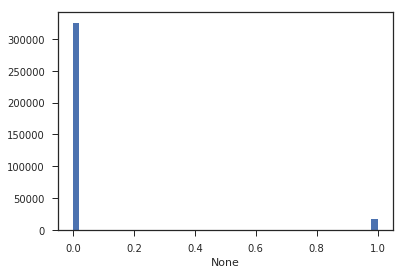

Ind_Prod_02
Histograma:


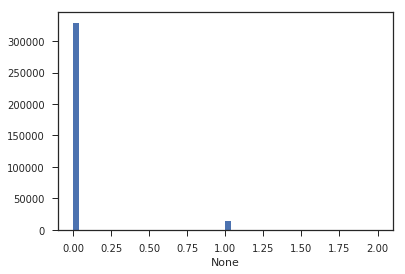

Ind_Prod_03
Histograma:


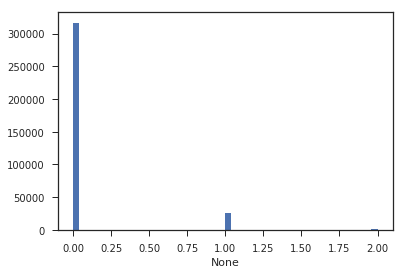

Ind_Prod_04
Histograma:


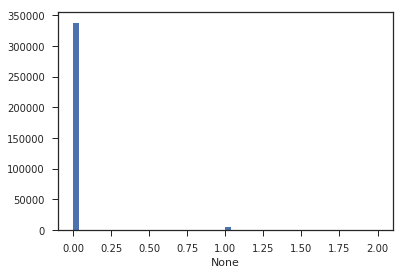

Ind_Prod_05
Histograma:


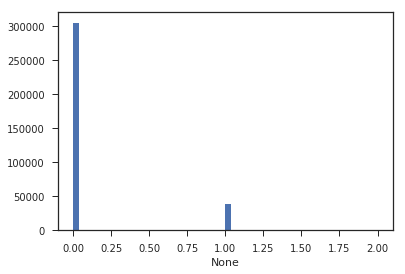

Ind_Prod_06
Histograma:


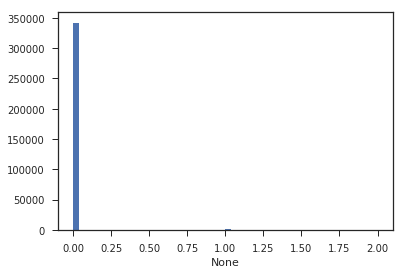

Ind_Prod_07
Histograma:


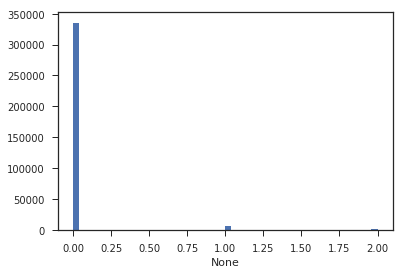

Ind_Prod_08
Histograma:


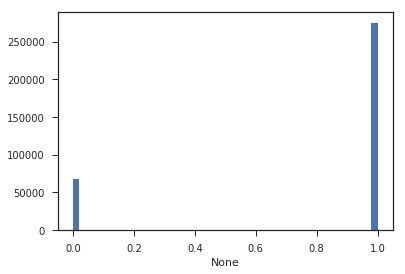

Ind_Prod_09
Histograma:


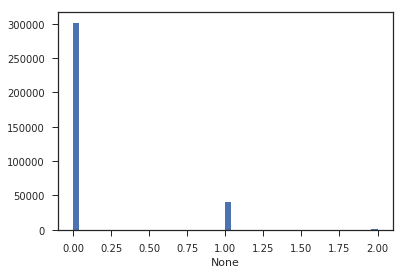

Ind_Prod_10
Histograma:


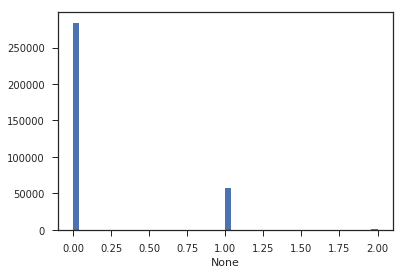

Ind_Prod_11
Histograma:


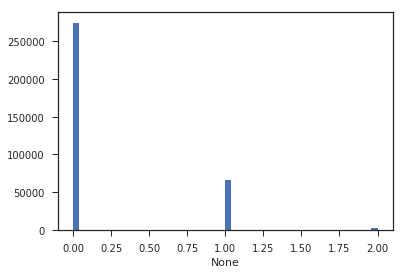

Ind_Prod_12
Histograma:


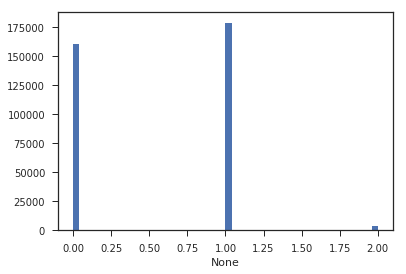

Ind_Prod_13
Histograma:


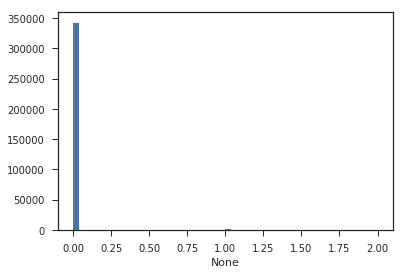

Ind_Prod_14
Histograma:


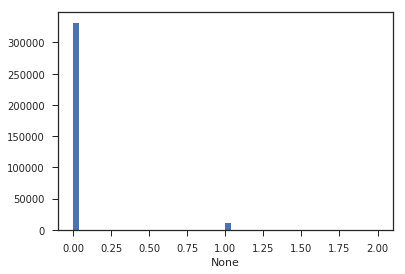

Ind_Prod_15
Histograma:


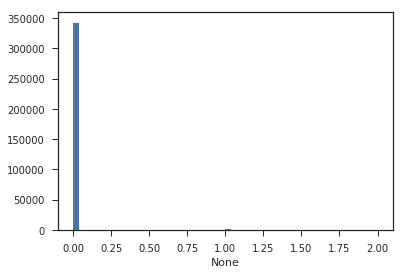

Ind_Prod_16
Histograma:


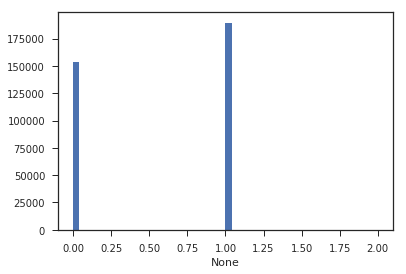

Ind_Prod_17
Histograma:


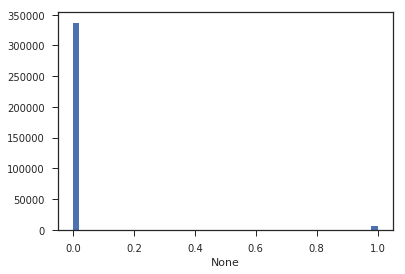

Ind_Prod_18
Histograma:


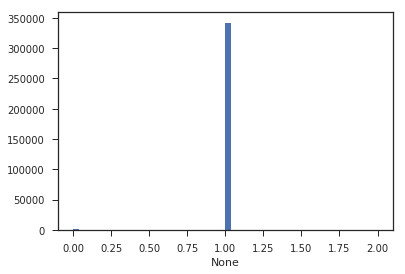

Ind_Prod_19
Histograma:


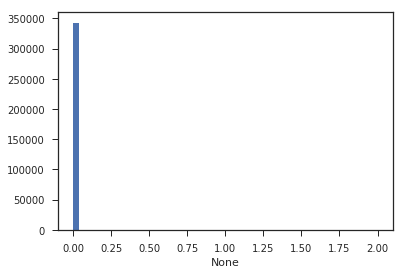

Ind_Prod_20
Histograma:


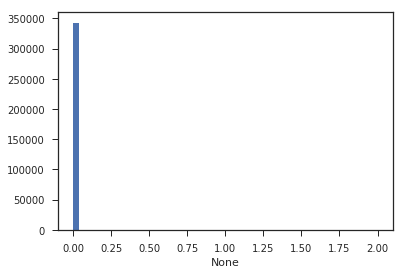

Ind_Prod_21
Histograma:


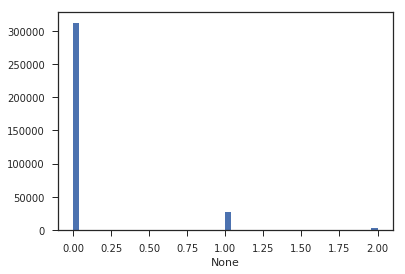

Ind_Prod_22
Histograma:


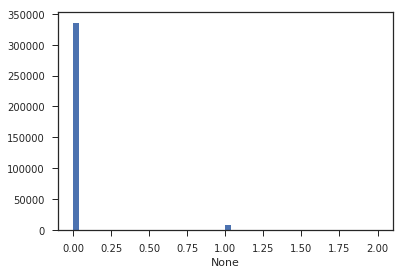

Ind_Prod_23
Histograma:


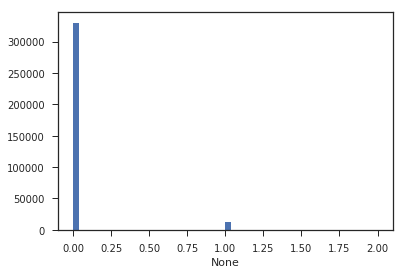

Ind_Prod_24
Histograma:


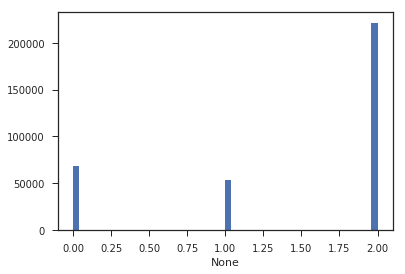

Socio_Demo_02
Histograma:


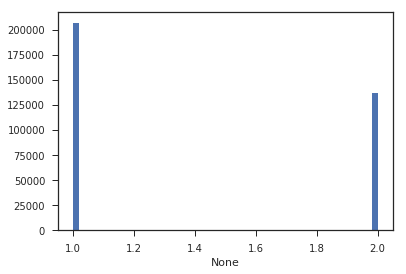

Socio_Demo_03
Histograma:


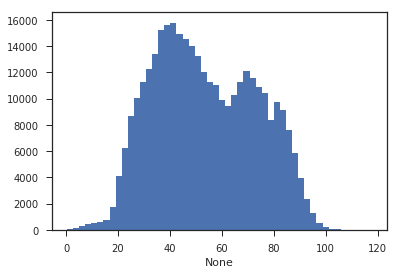

Socio_Demo_04
Histograma:


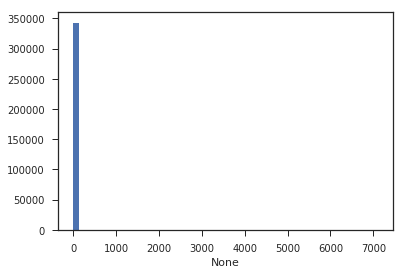

Socio_Demo_05
Histograma:


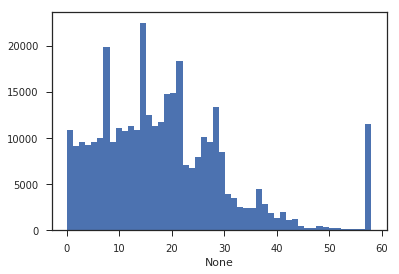

In [27]:
########################################
# HISTOGRAMAS POR BLOQUES DE VARIABLES #
########################################

histogramas_a_visualizar = [0, 0, 0 ,0, 1]

if (histogramas_a_visualizar[0]):
    mostrar_histograma_bloque('Imp_Cons')
    
if (histogramas_a_visualizar[1]):
    mostrar_histograma_bloque('Imp_Sal')
    
if (histogramas_a_visualizar[2]):   
    mostrar_histograma_bloque('Ind_Prod')
    
if (histogramas_a_visualizar[3]):   
    mostrar_histograma_bloque('Num_Oper')
                              
if (histogramas_a_visualizar[4]):                              
    mostrar_histograma_bloque('Socio_Demo')